# LSTM model을 활용한 작사가 만들기

## 라이브러리 Import 및 데이터 불러오기

In [1]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


- glob을 활용해서 모든 txt파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장

In [2]:
# 앞에서부터 10문장만 출력
for i in range(0, 9+1):
    print('sentence',i,':', raw_corpus[i])

sentence 0 : Now I've heard there was a secret chord
sentence 1 : That David played, and it pleased the Lord
sentence 2 : But you don't really care for music, do you?
sentence 3 : It goes like this
sentence 4 : The fourth, the fifth
sentence 5 : The minor fall, the major lift
sentence 6 : The baffled king composing Hallelujah Hallelujah
sentence 7 : Hallelujah
sentence 8 : Hallelujah
sentence 9 : Hallelujah Your faith was strong but you needed proof


## 데이터 전처리

preprocess_sentence() 사용

In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지운다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꾼다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다
#     5. 다시 양쪽 공백을 지운다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가한다

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 정제된 문장 모으기
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뛰기
    if len(sentence) == 0 : continue
                    
    # 정제를 하고 담기
    preprocessed_sentence = preprocess_sentence(sentence)
    # 토큰수 15를 맞추기 위해 조건문 넣기
    if len(preprocessed_sentence.split()) > 15 : continue
    corpus.append(preprocessed_sentence)   
    

# 정제된 결과를 10개정도 확인해보기
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [4]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들기
    # 우리는 이미 문장을 정제했으니 filters가 필요없다
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꾸기
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성하기
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환하기
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰준다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰준다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

print(len(tensor[0]))

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f5cacdad3a0>
15


- 토큰화된 토큰의 개수(len(tensor[0]))가 15개로 맞춰진 것을 확인할 수 있음

In [5]:
print(tensor[:3, :10])

# 생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력.

[[   2   50    4   95  303   62   53    9  946 6269]
 [   2   15 2971  872    5    8   11 5747    6  374]
 [   2   33    7   40   16  164  288   28  333    5]]


In [6]:
# tokenizer에 구축된 단어 사전의 인덱스
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [7]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성한다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성한다
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


## 모델 구성 및 학습

In [8]:
#평가 데이터셋 분리
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,       # 데이트셋 비율
                                                          shuffle=True, 
                                                          random_state=34)     # 결과를 일정하게 보여주기위해 지정

In [9]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)


In [10]:
from tensorflow.keras.layers import Embedding, LSTM, Dense


class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [11]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(256, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.68697225e-04,  4.28713029e-05,  1.60546930e-04, ...,
          1.52542270e-05, -5.05385760e-05,  1.83339012e-04],
        [ 2.43428090e-04, -8.45388058e-06,  1.61475677e-04, ...,
          2.66750048e-05, -9.50143876e-05,  2.27184224e-04],
        [ 2.29691665e-04, -3.46562243e-04,  2.55844410e-04, ...,
         -1.20071709e-04, -2.44516414e-04,  3.23712098e-04],
        ...,
        [-8.49107339e-04,  5.44982206e-04,  4.11134853e-04, ...,
          1.51517056e-03, -4.48030245e-04, -1.63203178e-04],
        [-1.11551443e-03,  8.32872116e-04,  5.63787413e-04, ...,
          1.54312898e-03, -6.78866403e-04, -2.96359474e-04],
        [-1.29885890e-03,  1.07933942e-03,  7.26016355e-04, ...,
          1.52162765e-03, -8.45325354e-04, -4.45611833e-04]],

       [[ 1.68697225e-04,  4.28713029e-05,  1.60546930e-04, ...,
          1.52542270e-05, -5.05385760e-05,  1.83339012e-04],
        [ 2.69114273e-04,  1.05391795e-04,  2

In [12]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  18882560  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, 
                    validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])  

Epoch 1/10
489/489 [==============================] - 231s 464ms/step - loss: 3.4585 - val_loss: 3.0083
Epoch 2/10
489/489 [==============================] - 241s 493ms/step - loss: 2.8388 - val_loss: 2.7348
Epoch 3/10
489/489 [==============================] - 245s 500ms/step - loss: 2.5388 - val_loss: 2.5557
Epoch 4/10
489/489 [==============================] - 245s 501ms/step - loss: 2.2487 - val_loss: 2.4172
Epoch 5/10
489/489 [==============================] - 246s 502ms/step - loss: 1.9727 - val_loss: 2.3182
Epoch 6/10
489/489 [==============================] - 245s 500ms/step - loss: 1.7195 - val_loss: 2.2393
Epoch 7/10
489/489 [==============================] - 245s 501ms/step - loss: 1.4992 - val_loss: 2.1903
Epoch 8/10
489/489 [==============================] - 246s 502ms/step - loss: 1.3173 - val_loss: 2.1691
Epoch 9/10
489/489 [==============================] - 246s 504ms/step - loss: 1.1785 - val_loss: 2.1677
Epoch 10/10
489/489 [==============================] - 246s 503m

## 모델 평가

<function matplotlib.pyplot.show(close=None, block=None)>

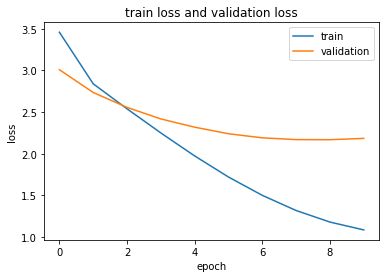

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

epoch가 증가함에 따라 train loss값은 1점대로 현저하게 떨어지나 검증셋은 2.5 수준으로 떨어짐을 확인함.

In [19]:
# 문장 생성 함수
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환함.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 함. 
    while True:
        predict = model(test_tensor)  
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   
    
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
  
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated  

In [20]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

## 모델 개선해보기

하이퍼파라미터 변경

In [31]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256   # 단어가 추상적으로 표현되는 크기(고려하는 feature의 수)
hidden_size = 1024     # 모델에 둘 일꾼의 수(많으면 배가 산으로)
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [32]:
embedding_size = 256
hidden_size = 1024
model2 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [33]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(256, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-6.60402293e-05,  8.57257182e-05,  6.99256725e-06, ...,
         -6.31421426e-05, -1.74272544e-04, -8.34657549e-05],
        [ 7.68151858e-06,  1.44254300e-04,  7.37792434e-05, ...,
         -1.63041375e-04, -3.43670166e-04, -1.66213955e-04],
        [ 6.89260269e-05,  3.25290762e-06,  2.71523721e-04, ...,
         -1.81497075e-04, -5.18042187e-04, -4.46222752e-04],
        ...,
        [-1.77369243e-03, -7.01336423e-04, -6.33119489e-04, ...,
         -4.21769131e-04,  3.89876514e-04, -7.06827443e-04],
        [-2.40335171e-03, -8.68442585e-04, -8.16173211e-04, ...,
         -8.48806289e-04,  7.81574403e-04, -8.15367617e-04],
        [-3.02999443e-03, -1.03172683e-03, -9.66078544e-04, ...,
         -1.28885161e-03,  1.18518167e-03, -9.59145487e-04]],

       [[-6.60402293e-05,  8.57257182e-05,  6.99256725e-06, ...,
         -6.31421426e-05, -1.74272544e-04, -8.34657549e-05],
        [-1.27876294e-04,  3.28861352e-04,  8

In [34]:
model.summary()

Model: "text_generator_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_7 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_4 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)


model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, 
                    validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])  


Epoch 1/10
489/489 [==============================] - 92s 183ms/step - loss: 3.4824 - val_loss: 3.1406
Epoch 2/10
489/489 [==============================] - 91s 186ms/step - loss: 3.0379 - val_loss: 2.9698
Epoch 3/10
489/489 [==============================] - 92s 187ms/step - loss: 2.8720 - val_loss: 2.8502
Epoch 4/10
489/489 [==============================] - 91s 187ms/step - loss: 2.7435 - val_loss: 2.7689
Epoch 5/10
489/489 [==============================] - 92s 188ms/step - loss: 2.6365 - val_loss: 2.7057
Epoch 6/10
489/489 [==============================] - 92s 188ms/step - loss: 2.5408 - val_loss: 2.6523
Epoch 7/10
489/489 [==============================] - 91s 187ms/step - loss: 2.4526 - val_loss: 2.6081
Epoch 8/10
489/489 [==============================] - 92s 188ms/step - loss: 2.3709 - val_loss: 2.5702
Epoch 9/10
489/489 [==============================] - 91s 187ms/step - loss: 2.2942 - val_loss: 2.5428
Epoch 10/10
489/489 [==============================] - 92s 188ms/step - l

<function matplotlib.pyplot.show(close=None, block=None)>

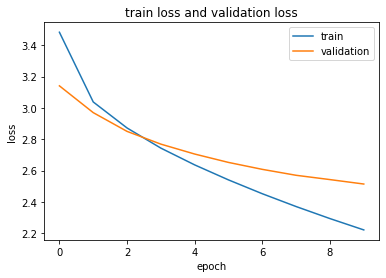

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show

### Report

- 중복되는 문장, 대괄호가 포함된 문장 삭제 등 데이터 정제 시행함.
- 15000개의 단어를 기억할 수 있는 tokenzier를 생성함.

- 에포크를 10보다 늘이거나,LSTM layer에 normalization을 적용하지 못했기에 다음 기회에 한번 시도해보려고함.

### 참고 사이트

Overfitting(과적합) 해결 \ https://velog.io/@yookyungkho/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%98-%EA%B3%A0%EC%A7%88%EB%B3%91-Overfitting%EA%B3%BC%EC%A0%81%ED%95%A9-%ED%95%B4%EA%B2%B0-%ED%8C%81

RNN과 LSTM을 이해해보자! \ https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

LSTM layer \ https://keras.io/api/layers/recurrent_layers/lstm/

file data 중복 제거 구현 \ https://velog.io/@cosmos/Python%EC%97%90%EC%84%9C-file-%EB%82%B4%EC%9A%A9-%EC%A4%91-%EC%A4%91%EB%B3%B5%EB%90%98%EB%8A%94-%EB%82%B4%EC%9A%A9-%EC%A0%9C%EA%B1%B0%ED%95%98%EA%B8%B0

ordereddict함수 \ https://hengbokhan.tistory.com/82

A Performance Analysis by Adjusting Learning Methods in Stock Price Prediction Model Using LSTM \ https://www.koreascience.or.kr/article/JAKO202034352379471.pdf